In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_PCA2.pth'


/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
from sklearn.decomposition import PCA
def extract_hidden_states(texts, model, tokenizer, apply_pca=True, n_components=2, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    
    # 应用 PCA 降维
    if apply_pca:
        pca = PCA(n_components=n_components)
        hidden_states = pca.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using PCA.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]
/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:43<00:00,  3.59it/s]


Hidden states reduced to 2 dimensions using PCA.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 373/373 [00:03<00:00, 96.66it/s] 


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [01:52<00:00,  3.14it/s]


Hidden states reduced to 2 dimensions using PCA.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 354/354 [00:03<00:00, 107.39it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=770 and hidden_dim=256


Training Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Epochs:   1%|          | 14/2000 [00:00<00:55, 35.61it/s]

Epoch 10/2000, Loss: 0.5959
Test Accuracy at Epoch 10: 55.94%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.60      0.28      0.38       283
non_infringement       0.55      0.83      0.66       298

        accuracy                           0.56       581
       macro avg       0.57      0.55      0.52       581
    weighted avg       0.57      0.56      0.52       581

New best model saved with accuracy 55.94% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.60      0.28      0.38       283
non_infringement       0.55      0.83      0.66       298

        accuracy                           0.56       581
       macro avg       0.57      0.55      0.52       581
    weighted avg       0.57      0.56      0.52       581



Training Epochs:   2%|▏         | 30/2000 [00:00<00:49, 40.09it/s]

Epoch 20/2000, Loss: 0.4923
Test Accuracy at Epoch 20: 60.76%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.60      0.58      0.59       283
non_infringement       0.61      0.63      0.62       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

New best model saved with accuracy 60.76% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.60      0.58      0.59       283
non_infringement       0.61      0.63      0.62       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 30/2000, Loss: 0.4099
Test Accuracy at Epoch 30: 74.18%
Classification Report at Epoch 30:
          

Training Epochs:   2%|▎         | 50/2000 [00:01<00:41, 46.98it/s]

Epoch 40/2000, Loss: 0.3303
Test Accuracy at Epoch 40: 75.04%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.72       283
non_infringement       0.72      0.85      0.78       298

        accuracy                           0.75       581
       macro avg       0.76      0.75      0.75       581
    weighted avg       0.76      0.75      0.75       581

New best model saved with accuracy 75.04% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.72       283
non_infringement       0.72      0.85      0.78       298

        accuracy                           0.75       581
       macro avg       0.76      0.75      0.75       581
    weighted avg       0.76      0.75      0.75       581

Epoch 50/2000, Loss: 0.2853
Test Accuracy at Epoch 50: 75.22%
Classification Report at Epoch 50:
          

Training Epochs:   4%|▎         | 70/2000 [00:01<00:35, 53.62it/s]

Epoch 60/2000, Loss: 0.2631
Test Accuracy at Epoch 60: 74.87%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       283
non_infringement       0.72      0.84      0.77       298

        accuracy                           0.75       581
       macro avg       0.76      0.75      0.75       581
    weighted avg       0.76      0.75      0.75       581

Epoch 70/2000, Loss: 0.2244
Test Accuracy at Epoch 70: 69.19%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.78      0.52      0.62       283
non_infringement       0.65      0.86      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581



Training Epochs:   4%|▍         | 90/2000 [00:02<00:39, 48.45it/s]

Epoch 80/2000, Loss: 0.1959
Test Accuracy at Epoch 80: 66.95%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.47      0.58       283
non_infringement       0.63      0.86      0.73       298

        accuracy                           0.67       581
       macro avg       0.69      0.66      0.65       581
    weighted avg       0.69      0.67      0.66       581

Epoch 90/2000, Loss: 0.1945
Test Accuracy at Epoch 90: 68.50%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.80      0.47      0.59       283
non_infringement       0.64      0.89      0.74       298

        accuracy                           0.69       581
       macro avg       0.72      0.68      0.67       581
    weighted avg       0.72      0.69      0.67       581



Training Epochs:   5%|▌         | 107/2000 [00:02<00:41, 45.33it/s]

Epoch 100/2000, Loss: 0.1585
Test Accuracy at Epoch 100: 71.77%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.81      0.54      0.65       283
non_infringement       0.67      0.88      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.71      0.71       581
    weighted avg       0.74      0.72      0.71       581

Epoch 110/2000, Loss: 0.1413


Training Epochs:   6%|▌         | 112/2000 [00:02<00:45, 41.69it/s]

Test Accuracy at Epoch 110: 74.53%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.82      0.61      0.70       283
non_infringement       0.70      0.87      0.78       298

        accuracy                           0.75       581
       macro avg       0.76      0.74      0.74       581
    weighted avg       0.76      0.75      0.74       581



Training Epochs:   6%|▌         | 124/2000 [00:02<00:40, 46.16it/s]

Epoch 120/2000, Loss: 0.1331
Test Accuracy at Epoch 120: 71.08%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.81      0.53      0.64       283
non_infringement       0.66      0.88      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.71      0.70       581
    weighted avg       0.73      0.71      0.70       581



Training Epochs:   7%|▋         | 137/2000 [00:03<00:38, 48.76it/s]

Epoch 130/2000, Loss: 0.1117
Test Accuracy at Epoch 130: 71.94%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.79      0.57      0.67       283
non_infringement       0.68      0.86      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.71       581
    weighted avg       0.74      0.72      0.71       581

Epoch 140/2000, Loss: 0.1054
Test Accuracy at Epoch 140: 69.71%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.81      0.49      0.61       283
non_infringement       0.65      0.89      0.75       298

        accuracy                           0.70       581
       macro avg       0.73      0.69      0.68       581
    weighted avg       0.73      0.70      0.68       581



Training Epochs:   8%|▊         | 157/2000 [00:03<00:36, 50.33it/s]

Epoch 150/2000, Loss: 0.0972
Test Accuracy at Epoch 150: 72.81%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.81      0.57      0.67       283
non_infringement       0.68      0.88      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.72      0.72       581
    weighted avg       0.75      0.73      0.72       581

Epoch 160/2000, Loss: 0.0834
Test Accuracy at Epoch 160: 72.29%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.81      0.57      0.67       283
non_infringement       0.68      0.87      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.71       581
    weighted avg       0.74      0.72      0.72       581



Training Epochs:   8%|▊         | 164/2000 [00:03<00:34, 53.05it/s]

Epoch 170/2000, Loss: 0.0707
Test Accuracy at Epoch 170: 73.67%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       283
non_infringement       0.70      0.87      0.77       298

        accuracy                           0.74       581
       macro avg       0.75      0.73      0.73       581
    weighted avg       0.75      0.74      0.73       581



Training Epochs:   9%|▉         | 184/2000 [00:04<00:45, 39.72it/s]

Epoch 180/2000, Loss: 0.0839
Test Accuracy at Epoch 180: 68.67%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.85      0.43      0.57       283
non_infringement       0.63      0.93      0.75       298

        accuracy                           0.69       581
       macro avg       0.74      0.68      0.66       581
    weighted avg       0.74      0.69      0.67       581



Training Epochs:  10%|█         | 200/2000 [00:04<00:34, 52.91it/s]

Epoch 190/2000, Loss: 0.2041
Test Accuracy at Epoch 190: 70.05%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.83      0.48      0.61       283
non_infringement       0.65      0.91      0.76       298

        accuracy                           0.70       581
       macro avg       0.74      0.69      0.68       581
    weighted avg       0.74      0.70      0.69       581

Epoch 200/2000, Loss: 0.1472
Test Accuracy at Epoch 200: 72.12%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.82      0.55      0.66       283
non_infringement       0.67      0.88      0.76       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.74      0.72      0.71       581



Training Epochs:  11%|█         | 221/2000 [00:04<00:31, 56.44it/s]

Epoch 210/2000, Loss: 0.0854
Test Accuracy at Epoch 210: 73.15%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.70       283
non_infringement       0.71      0.80      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.73      0.73      0.73       581

Epoch 220/2000, Loss: 0.0784
Test Accuracy at Epoch 220: 72.98%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.77      0.63      0.70       283
non_infringement       0.70      0.82      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



Training Epochs:  12%|█▏        | 244/2000 [00:05<00:28, 61.84it/s]

Epoch 230/2000, Loss: 0.0658
Test Accuracy at Epoch 230: 73.15%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       283
non_infringement       0.70      0.84      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 240/2000, Loss: 0.0596
Test Accuracy at Epoch 240: 74.18%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.82      0.60      0.69       283
non_infringement       0.70      0.88      0.78       298

        accuracy                           0.74       581
       macro avg       0.76      0.74      0.74       581
    weighted avg       0.76      0.74      0.74       581



Training Epochs:  13%|█▎        | 259/2000 [00:05<00:30, 57.83it/s]

Epoch 250/2000, Loss: 0.0546
Test Accuracy at Epoch 250: 74.01%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.70       283
non_infringement       0.71      0.84      0.77       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.74      0.74       581



Training Epochs:  14%|█▍        | 275/2000 [00:05<00:25, 67.07it/s]

Epoch 260/2000, Loss: 0.0509
Test Accuracy at Epoch 260: 74.01%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.70       283
non_infringement       0.71      0.84      0.77       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.74      0.74       581

Epoch 270/2000, Loss: 0.0478
Test Accuracy at Epoch 270: 73.84%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.70       283
non_infringement       0.71      0.84      0.77       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.73       581
    weighted avg       0.75      0.74      0.74       581



Training Epochs:  14%|█▍        | 290/2000 [00:05<00:27, 61.68it/s]

Epoch 280/2000, Loss: 0.0451
Test Accuracy at Epoch 280: 72.63%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       283
non_infringement       0.69      0.84      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 290/2000, Loss: 0.0426
Test Accuracy at Epoch 290: 71.94%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.67       283
non_infringement       0.69      0.84      0.75       298

        accuracy                           0.72       581
       macro avg       0.73      0.72      0.71       581
    weighted avg       0.73      0.72      0.72       581



Training Epochs:  15%|█▌        | 307/2000 [00:06<00:27, 60.88it/s]

Epoch 300/2000, Loss: 0.0403
Test Accuracy at Epoch 300: 70.05%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.76      0.56      0.64       283
non_infringement       0.67      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581

Epoch 310/2000, Loss: 0.0382
Test Accuracy at Epoch 310: 69.88%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  16%|█▌        | 322/2000 [00:06<00:26, 64.34it/s]

Epoch 320/2000, Loss: 0.0363
Test Accuracy at Epoch 320: 69.88%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  17%|█▋        | 337/2000 [00:06<00:27, 60.05it/s]

Epoch 330/2000, Loss: 0.0345
Test Accuracy at Epoch 330: 70.40%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.77      0.56      0.65       283
non_infringement       0.67      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.70      0.70       581

Epoch 340/2000, Loss: 0.0328
Test Accuracy at Epoch 340: 69.88%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  18%|█▊        | 351/2000 [00:07<00:30, 53.20it/s]

Epoch 350/2000, Loss: 0.0311
Test Accuracy at Epoch 350: 69.88%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  18%|█▊        | 368/2000 [00:07<00:25, 64.04it/s]

Epoch 360/2000, Loss: 0.0296
Test Accuracy at Epoch 360: 69.54%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.83      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581

Epoch 370/2000, Loss: 0.0282
Test Accuracy at Epoch 370: 69.54%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.83      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  20%|█▉        | 391/2000 [00:07<00:25, 63.69it/s]

Epoch 380/2000, Loss: 0.0268
Test Accuracy at Epoch 380: 69.54%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.83      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581

Epoch 390/2000, Loss: 0.0255
Test Accuracy at Epoch 390: 69.54%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.83      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  20%|██        | 407/2000 [00:07<00:25, 63.09it/s]

Epoch 400/2000, Loss: 0.0243
Test Accuracy at Epoch 400: 69.71%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581

Epoch 410/2000, Loss: 0.0231
Test Accuracy at Epoch 410: 69.71%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  21%|██        | 423/2000 [00:08<00:22, 69.44it/s]

Epoch 420/2000, Loss: 0.0220
Test Accuracy at Epoch 420: 69.71%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581

Epoch 430/2000, Loss: 0.0210
Test Accuracy at Epoch 430: 69.88%


Training Epochs:  22%|██▏       | 440/2000 [00:08<00:23, 65.37it/s]

Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581

Epoch 440/2000, Loss: 0.0200
Test Accuracy at Epoch 440: 69.88%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  23%|██▎       | 457/2000 [00:08<00:25, 60.51it/s]

Epoch 450/2000, Loss: 0.0190
Test Accuracy at Epoch 450: 69.88%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.76      0.55      0.64       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  24%|██▎       | 473/2000 [00:08<00:22, 67.15it/s]

Epoch 460/2000, Loss: 0.0180
Test Accuracy at Epoch 460: 69.19%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.76      0.54      0.63       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581

Epoch 470/2000, Loss: 0.0170
Test Accuracy at Epoch 470: 69.19%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.76      0.54      0.63       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581



Training Epochs:  24%|██▍       | 489/2000 [00:09<00:23, 63.82it/s]

Epoch 480/2000, Loss: 0.0160
Test Accuracy at Epoch 480: 69.19%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.76      0.54      0.63       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581

Epoch 490/2000, Loss: 0.0149
Test Accuracy at Epoch 490: 69.54%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.77      0.54      0.63       283
non_infringement       0.66      0.85      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  25%|██▌       | 505/2000 [00:09<00:24, 61.29it/s]

Epoch 500/2000, Loss: 0.0137
Test Accuracy at Epoch 500: 69.19%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.76      0.53      0.63       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581

Epoch 510/2000, Loss: 0.0125
Test Accuracy at Epoch 510: 67.30%
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.72      0.53      0.61       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  27%|██▋       | 531/2000 [00:09<00:20, 72.70it/s]

Epoch 520/2000, Loss: 0.0114
Test Accuracy at Epoch 520: 66.95%
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.72      0.53      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 530/2000, Loss: 0.0104
Test Accuracy at Epoch 530: 67.30%
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.72      0.53      0.61       283
non_infringement       0.64      0.81      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  27%|██▋       | 547/2000 [00:10<00:22, 64.91it/s]

Epoch 540/2000, Loss: 0.0096
Test Accuracy at Epoch 540: 66.95%
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.72      0.53      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 550/2000, Loss: 0.0088
Test Accuracy at Epoch 550: 66.95%
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.71      0.54      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  28%|██▊       | 570/2000 [00:10<00:22, 63.97it/s]

Epoch 560/2000, Loss: 0.0082
Test Accuracy at Epoch 560: 67.13%
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.72      0.53      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 570/2000, Loss: 0.0076
Test Accuracy at Epoch 570: 66.61%
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.71      0.53      0.61       283
non_infringement       0.64      0.79      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.67      0.67      0.66       581



Training Epochs:  29%|██▉       | 587/2000 [00:10<00:23, 59.94it/s]

Epoch 580/2000, Loss: 0.0071
Test Accuracy at Epoch 580: 66.95%
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.71      0.54      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  30%|███       | 601/2000 [00:10<00:23, 60.00it/s]

Epoch 590/2000, Loss: 0.0067
Test Accuracy at Epoch 590: 68.33%
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.63       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 600/2000, Loss: 0.0062
Test Accuracy at Epoch 600: 68.33%
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.73      0.56      0.63       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  31%|███▏      | 625/2000 [00:11<00:20, 65.52it/s]

Epoch 610/2000, Loss: 0.0059
Test Accuracy at Epoch 610: 68.50%
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.73      0.56      0.63       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.69       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.69      0.68       581

Epoch 620/2000, Loss: 0.0055
Test Accuracy at Epoch 620: 68.67%
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.69      0.69      0.68       581



Training Epochs:  32%|███▏      | 640/2000 [00:11<00:23, 59.06it/s]

Epoch 630/2000, Loss: 0.0052
Test Accuracy at Epoch 630: 68.67%
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.69      0.69      0.68       581

Epoch 640/2000, Loss: 0.0049
Test Accuracy at Epoch 640: 68.67%
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.69      0.69      0.68       581



Training Epochs:  33%|███▎      | 657/2000 [00:11<00:22, 58.42it/s]

Epoch 650/2000, Loss: 0.0047
Test Accuracy at Epoch 650: 68.85%
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.69      0.68       581
    weighted avg       0.70      0.69      0.68       581

Epoch 660/2000, Loss: 0.0045


Training Epochs:  34%|███▎      | 674/2000 [00:12<00:19, 67.86it/s]

Test Accuracy at Epoch 660: 68.85%
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.69      0.68       581
    weighted avg       0.70      0.69      0.68       581

Epoch 670/2000, Loss: 0.0042
Test Accuracy at Epoch 670: 68.85%
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.69      0.68       581
    weighted avg       0.70      0.69      0.68       581



Training Epochs:  35%|███▍      | 691/2000 [00:12<00:20, 63.04it/s]

Epoch 680/2000, Loss: 0.0040
Test Accuracy at Epoch 680: 68.85%
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.69      0.68       581
    weighted avg       0.70      0.69      0.68       581

Epoch 690/2000, Loss: 0.0038
Test Accuracy at Epoch 690: 68.67%
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.69      0.69      0.68       581



Training Epochs:  35%|███▌      | 705/2000 [00:12<00:23, 56.01it/s]

Epoch 700/2000, Loss: 0.0037
Test Accuracy at Epoch 700: 68.67%
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       283
non_infringement       0.66      0.80      0.72       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.69      0.69      0.68       581

Epoch 710/2000, Loss: 0.0035


Training Epochs:  36%|███▌      | 722/2000 [00:12<00:19, 66.68it/s]

Test Accuracy at Epoch 710: 68.67%
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.74      0.55      0.63       283
non_infringement       0.66      0.82      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.70      0.69      0.68       581

Epoch 720/2000, Loss: 0.0034
Test Accuracy at Epoch 720: 68.67%
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.74      0.55      0.63       283
non_infringement       0.66      0.82      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.70      0.69      0.68       581



Training Epochs:  37%|███▋      | 739/2000 [00:13<00:18, 66.82it/s]

Epoch 730/2000, Loss: 0.0032
Test Accuracy at Epoch 730: 68.33%
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 740/2000, Loss: 0.0031
Test Accuracy at Epoch 740: 68.33%
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  38%|███▊      | 756/2000 [00:13<00:20, 61.17it/s]

Epoch 750/2000, Loss: 0.0030
Test Accuracy at Epoch 750: 68.33%
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 760/2000, Loss: 0.0029
Test Accuracy at Epoch 760: 68.33%


Training Epochs:  39%|███▊      | 772/2000 [00:13<00:18, 67.69it/s]

Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 770/2000, Loss: 0.0027
Test Accuracy at Epoch 770: 68.33%
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  39%|███▉      | 788/2000 [00:13<00:19, 62.64it/s]

Epoch 780/2000, Loss: 0.0027
Test Accuracy at Epoch 780: 68.33%
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 790/2000, Loss: 0.0026
Test Accuracy at Epoch 790: 68.33%


Training Epochs:  40%|████      | 804/2000 [00:14<00:17, 67.61it/s]

Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 800/2000, Loss: 0.0025
Test Accuracy at Epoch 800: 68.33%
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  41%|████      | 820/2000 [00:14<00:18, 62.97it/s]

Epoch 810/2000, Loss: 0.0024
Test Accuracy at Epoch 810: 68.16%
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581

Epoch 820/2000, Loss: 0.0023
Test Accuracy at Epoch 820: 68.16%
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  42%|████▏     | 837/2000 [00:14<00:19, 60.16it/s]

Epoch 830/2000, Loss: 0.0022
Test Accuracy at Epoch 830: 68.16%
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581

Epoch 840/2000, Loss: 0.0022
Test Accuracy at Epoch 840: 68.16%


Training Epochs:  43%|████▎     | 853/2000 [00:14<00:17, 67.06it/s]

Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581

Epoch 850/2000, Loss: 0.0021
Test Accuracy at Epoch 850: 68.16%
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  44%|████▎     | 870/2000 [00:15<00:17, 64.88it/s]

Epoch 860/2000, Loss: 0.0021
Test Accuracy at Epoch 860: 68.33%
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 870/2000, Loss: 0.0020
Test Accuracy at Epoch 870: 68.33%
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  44%|████▍     | 887/2000 [00:15<00:18, 61.61it/s]

Epoch 880/2000, Loss: 0.0019
Test Accuracy at Epoch 880: 68.33%
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

Epoch 890/2000, Loss: 0.0019
Test Accuracy at Epoch 890: 68.16%


Training Epochs:  45%|████▌     | 902/2000 [00:15<00:17, 62.58it/s]

Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.74      0.54      0.62       283
non_infringement       0.65      0.82      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581

Epoch 900/2000, Loss: 0.0018
Test Accuracy at Epoch 900: 68.16%
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.74      0.54      0.62       283
non_infringement       0.65      0.82      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  46%|████▌     | 917/2000 [00:15<00:17, 61.50it/s]

Epoch 910/2000, Loss: 0.0018
Test Accuracy at Epoch 910: 68.16%
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.74      0.54      0.62       283
non_infringement       0.65      0.82      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581

Epoch 920/2000, Loss: 0.0017
Test Accuracy at Epoch 920: 68.16%
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.74      0.54      0.62       283
non_infringement       0.65      0.82      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  47%|████▋     | 939/2000 [00:16<00:17, 60.87it/s]

Epoch 930/2000, Loss: 0.0017
Test Accuracy at Epoch 930: 68.16%
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.74      0.54      0.62       283
non_infringement       0.65      0.82      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  47%|████▋     | 946/2000 [00:16<00:17, 61.24it/s]

Epoch 940/2000, Loss: 0.0017
Test Accuracy at Epoch 940: 68.16%
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.74      0.54      0.62       283
non_infringement       0.65      0.82      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581

Epoch 950/2000, Loss: 0.0016
Test Accuracy at Epoch 950: 67.30%
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.66       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  49%|████▊     | 971/2000 [00:16<00:19, 52.87it/s]

Epoch 960/2000, Loss: 0.0016
Test Accuracy at Epoch 960: 67.47%
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.73      0.53      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.67       581
    weighted avg       0.69      0.67      0.67       581

Epoch 970/2000, Loss: 0.0015
Test Accuracy at Epoch 970: 67.30%
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.66       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  50%|████▉     | 991/2000 [00:17<00:17, 56.35it/s]

Epoch 980/2000, Loss: 0.0015
Test Accuracy at Epoch 980: 67.30%
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.66       581
    weighted avg       0.68      0.67      0.67       581

Epoch 990/2000, Loss: 0.0015
Test Accuracy at Epoch 990: 67.13%
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  51%|█████     | 1012/2000 [00:17<00:16, 59.70it/s]

Epoch 1000/2000, Loss: 0.0014
Test Accuracy at Epoch 1000: 67.13%
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1010/2000, Loss: 0.0014
Test Accuracy at Epoch 1010: 67.13%
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  51%|█████▏    | 1026/2000 [00:17<00:16, 58.33it/s]

Epoch 1020/2000, Loss: 0.0014
Test Accuracy at Epoch 1020: 67.13%
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1030/2000, Loss: 0.0014
Test Accuracy at Epoch 1030: 67.13%
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  52%|█████▏    | 1048/2000 [00:18<00:17, 53.35it/s]

Epoch 1040/2000, Loss: 0.0013
Test Accuracy at Epoch 1040: 67.13%
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.61       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1050/2000, Loss: 0.0013
Test Accuracy at Epoch 1050: 66.95%
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.60       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  53%|█████▎    | 1062/2000 [00:18<00:17, 52.34it/s]

Epoch 1060/2000, Loss: 0.0013
Test Accuracy at Epoch 1060: 66.95%
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.60       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1070/2000, Loss: 0.0013
Test Accuracy at Epoch 1070: 66.61%


Training Epochs:  54%|█████▍    | 1078/2000 [00:18<00:14, 61.67it/s]

Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1080/2000, Loss: 0.0012
Test Accuracy at Epoch 1080: 66.61%
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  55%|█████▌    | 1100/2000 [00:19<00:14, 60.89it/s]

Epoch 1090/2000, Loss: 0.0012
Test Accuracy at Epoch 1090: 66.61%
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1100/2000, Loss: 0.0012
Test Accuracy at Epoch 1100: 66.61%
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  56%|█████▌    | 1122/2000 [00:19<00:13, 63.75it/s]

Epoch 1110/2000, Loss: 0.0011
Test Accuracy at Epoch 1110: 66.44%
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.59       283
non_infringement       0.63      0.82      0.71       298

        accuracy                           0.66       581
       macro avg       0.68      0.66      0.65       581
    weighted avg       0.68      0.66      0.66       581

Epoch 1120/2000, Loss: 0.0011
Test Accuracy at Epoch 1120: 66.61%
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  57%|█████▋    | 1136/2000 [00:19<00:15, 54.90it/s]

Epoch 1130/2000, Loss: 0.0011
Test Accuracy at Epoch 1130: 66.61%
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1140/2000, Loss: 0.0011
Test Accuracy at Epoch 1140: 66.61%


Training Epochs:  58%|█████▊    | 1151/2000 [00:20<00:13, 63.23it/s]

Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581

Epoch 1150/2000, Loss: 0.0011
Test Accuracy at Epoch 1150: 66.61%
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.60       283
non_infringement       0.64      0.82      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  59%|█████▊    | 1173/2000 [00:20<00:12, 64.45it/s]

Epoch 1160/2000, Loss: 0.0010
Test Accuracy at Epoch 1160: 68.50%
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.77      0.51      0.61       283
non_infringement       0.65      0.86      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581

Epoch 1170/2000, Loss: 0.0010
Test Accuracy at Epoch 1170: 68.33%
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.61       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  59%|█████▉    | 1181/2000 [00:20<00:14, 58.15it/s]

Epoch 1180/2000, Loss: 0.0010
Test Accuracy at Epoch 1180: 68.33%
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.61       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581

Epoch 1190/2000, Loss: 0.0010
Test Accuracy at Epoch 1190: 68.33%


Training Epochs:  60%|█████▉    | 1198/2000 [00:20<00:12, 65.96it/s]

Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.61       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581

Epoch 1200/2000, Loss: 0.0010
Test Accuracy at Epoch 1200: 68.33%
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.61       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  61%|██████    | 1218/2000 [00:21<00:14, 54.33it/s]

Epoch 1210/2000, Loss: 0.0009
Test Accuracy at Epoch 1210: 68.33%
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.61       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581

Epoch 1220/2000, Loss: 0.0009
Test Accuracy at Epoch 1220: 68.33%
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.61       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  62%|██████▏   | 1237/2000 [00:21<00:13, 56.40it/s]

Epoch 1230/2000, Loss: 0.0009
Test Accuracy at Epoch 1230: 68.33%
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.61       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581

Epoch 1240/2000, Loss: 0.0009
Test Accuracy at Epoch 1240: 68.16%
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.77      0.50      0.60       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.70      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  63%|██████▎   | 1260/2000 [00:21<00:12, 59.77it/s]

Epoch 1250/2000, Loss: 0.0009
Test Accuracy at Epoch 1250: 68.16%
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.77      0.49      0.60       283
non_infringement       0.64      0.86      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581

Epoch 1260/2000, Loss: 0.0008
Test Accuracy at Epoch 1260: 68.67%
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581



Training Epochs:  64%|██████▍   | 1276/2000 [00:22<00:12, 58.68it/s]

Epoch 1270/2000, Loss: 0.0008
Test Accuracy at Epoch 1270: 68.67%
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581



Training Epochs:  64%|██████▍   | 1290/2000 [00:22<00:11, 61.16it/s]

Epoch 1280/2000, Loss: 0.0009
Test Accuracy at Epoch 1280: 68.67%
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581

Epoch 1290/2000, Loss: 0.0008
Test Accuracy at Epoch 1290: 68.67%
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581



Training Epochs:  66%|██████▌   | 1310/2000 [00:22<00:11, 58.95it/s]

Epoch 1300/2000, Loss: 0.0008
Test Accuracy at Epoch 1300: 68.67%
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581

Epoch 1310/2000, Loss: 0.0008
Test Accuracy at Epoch 1310: 68.67%
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581



Training Epochs:  67%|██████▋   | 1331/2000 [00:23<00:12, 55.58it/s]

Epoch 1320/2000, Loss: 0.0007
Test Accuracy at Epoch 1320: 68.67%
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581

Epoch 1330/2000, Loss: 0.0007
Test Accuracy at Epoch 1330: 68.67%
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581



Training Epochs:  67%|██████▋   | 1349/2000 [00:23<00:10, 62.52it/s]

Epoch 1340/2000, Loss: 0.0007
Test Accuracy at Epoch 1340: 68.67%
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.61       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.69      0.67       581

Epoch 1350/2000, Loss: 0.0007
Test Accuracy at Epoch 1350: 67.47%
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581



Training Epochs:  68%|██████▊   | 1364/2000 [00:23<00:09, 66.21it/s]

Epoch 1360/2000, Loss: 0.0007
Test Accuracy at Epoch 1360: 67.47%
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581



Training Epochs:  69%|██████▉   | 1380/2000 [00:24<00:10, 58.13it/s]

Epoch 1370/2000, Loss: 0.0007
Test Accuracy at Epoch 1370: 67.64%
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.59       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.68       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.68      0.66       581

Epoch 1380/2000, Loss: 0.0007
Test Accuracy at Epoch 1380: 67.47%
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581



Training Epochs:  70%|███████   | 1403/2000 [00:24<00:09, 61.89it/s]

Epoch 1390/2000, Loss: 0.0006
Test Accuracy at Epoch 1390: 67.47%
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581

Epoch 1400/2000, Loss: 0.0006
Test Accuracy at Epoch 1400: 67.47%
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581



Training Epochs:  71%|███████   | 1418/2000 [00:24<00:09, 59.69it/s]

Epoch 1410/2000, Loss: 0.0006
Test Accuracy at Epoch 1410: 67.47%
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581



Training Epochs:  72%|███████▏  | 1434/2000 [00:24<00:08, 65.86it/s]

Epoch 1420/2000, Loss: 0.0006
Test Accuracy at Epoch 1420: 67.47%
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581

Epoch 1430/2000, Loss: 0.0006
Test Accuracy at Epoch 1430: 67.47%
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.77      0.47      0.58       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.67      0.66       581
    weighted avg       0.70      0.67      0.66       581



Training Epochs:  72%|███████▏  | 1449/2000 [00:25<00:08, 61.89it/s]

Epoch 1440/2000, Loss: 0.0006
Test Accuracy at Epoch 1440: 67.64%
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.78      0.47      0.59       283
non_infringement       0.63      0.87      0.73       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.70      0.68      0.66       581

Epoch 1450/2000, Loss: 0.0006
Test Accuracy at Epoch 1450: 68.33%
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  74%|███████▎  | 1470/2000 [00:25<00:09, 54.02it/s]

Epoch 1460/2000, Loss: 0.0006
Test Accuracy at Epoch 1460: 68.33%
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1470/2000, Loss: 0.0005
Test Accuracy at Epoch 1470: 68.16%
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  75%|███████▍  | 1493/2000 [00:25<00:08, 58.54it/s]

Epoch 1480/2000, Loss: 0.0005
Test Accuracy at Epoch 1480: 68.16%
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1490/2000, Loss: 0.0005
Test Accuracy at Epoch 1490: 68.16%
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  75%|███████▌  | 1508/2000 [00:26<00:08, 59.46it/s]

Epoch 1500/2000, Loss: 0.0005
Test Accuracy at Epoch 1500: 68.16%
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1510/2000, Loss: 0.0005
Test Accuracy at Epoch 1510: 68.16%
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  76%|███████▋  | 1530/2000 [00:26<00:07, 65.17it/s]

Epoch 1520/2000, Loss: 0.0005
Test Accuracy at Epoch 1520: 67.99%
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1530/2000, Loss: 0.0005
Test Accuracy at Epoch 1530: 67.99%
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  78%|███████▊  | 1553/2000 [00:26<00:06, 68.21it/s]

Epoch 1540/2000, Loss: 0.0005
Test Accuracy at Epoch 1540: 67.99%
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1550/2000, Loss: 0.0005
Test Accuracy at Epoch 1550: 67.99%
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  78%|███████▊  | 1568/2000 [00:27<00:07, 58.66it/s]

Epoch 1560/2000, Loss: 0.0005
Test Accuracy at Epoch 1560: 68.16%
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1570/2000, Loss: 0.0004
Test Accuracy at Epoch 1570: 68.16%
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  80%|███████▉  | 1590/2000 [00:27<00:07, 57.67it/s]

Epoch 1580/2000, Loss: 0.0004
Test Accuracy at Epoch 1580: 68.16%
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1590/2000, Loss: 0.0004
Test Accuracy at Epoch 1590: 68.16%
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  81%|████████  | 1613/2000 [00:28<00:06, 56.53it/s]

Epoch 1600/2000, Loss: 0.0004
Test Accuracy at Epoch 1600: 68.16%
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1610/2000, Loss: 0.0004
Test Accuracy at Epoch 1610: 68.16%
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  81%|████████▏ | 1628/2000 [00:28<00:07, 53.02it/s]

Epoch 1620/2000, Loss: 0.0004
Test Accuracy at Epoch 1620: 68.16%
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  82%|████████▏ | 1643/2000 [00:28<00:05, 62.22it/s]

Epoch 1630/2000, Loss: 0.0004
Test Accuracy at Epoch 1630: 68.16%
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1640/2000, Loss: 0.0004
Test Accuracy at Epoch 1640: 68.16%
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  83%|████████▎ | 1659/2000 [00:28<00:05, 60.63it/s]

Epoch 1650/2000, Loss: 0.0004
Test Accuracy at Epoch 1650: 67.99%
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1660/2000, Loss: 0.0004
Test Accuracy at Epoch 1660: 67.99%
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  84%|████████▍ | 1682/2000 [00:29<00:04, 65.02it/s]

Epoch 1670/2000, Loss: 0.0004
Test Accuracy at Epoch 1670: 68.16%
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1680/2000, Loss: 0.0004
Test Accuracy at Epoch 1680: 68.16%
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  85%|████████▍ | 1697/2000 [00:29<00:05, 57.58it/s]

Epoch 1690/2000, Loss: 0.0003
Test Accuracy at Epoch 1690: 68.16%
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  86%|████████▌ | 1712/2000 [00:29<00:04, 64.05it/s]

Epoch 1700/2000, Loss: 0.0003
Test Accuracy at Epoch 1700: 68.16%
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1710/2000, Loss: 0.0003
Test Accuracy at Epoch 1710: 68.16%
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  87%|████████▋ | 1733/2000 [00:30<00:04, 59.99it/s]

Epoch 1720/2000, Loss: 0.0003
Test Accuracy at Epoch 1720: 68.16%
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1730/2000, Loss: 0.0003
Test Accuracy at Epoch 1730: 68.16%
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  87%|████████▋ | 1747/2000 [00:30<00:04, 54.53it/s]

Epoch 1740/2000, Loss: 0.0003
Test Accuracy at Epoch 1740: 68.16%
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1750/2000, Loss: 0.0003
Test Accuracy at Epoch 1750: 68.16%


Training Epochs:  88%|████████▊ | 1763/2000 [00:30<00:03, 64.06it/s]

Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1760/2000, Loss: 0.0003
Test Accuracy at Epoch 1760: 68.16%
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  89%|████████▉ | 1779/2000 [00:30<00:03, 62.80it/s]

Epoch 1770/2000, Loss: 0.0003
Test Accuracy at Epoch 1770: 68.16%
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1780/2000, Loss: 0.0003
Test Accuracy at Epoch 1780: 68.16%
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  90%|████████▉ | 1793/2000 [00:31<00:03, 54.97it/s]

Epoch 1790/2000, Loss: 0.0003
Test Accuracy at Epoch 1790: 68.16%
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  90%|█████████ | 1807/2000 [00:31<00:03, 60.59it/s]

Epoch 1800/2000, Loss: 0.0003
Test Accuracy at Epoch 1800: 68.16%
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1810/2000, Loss: 0.0003
Test Accuracy at Epoch 1810: 68.16%
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  91%|█████████▏| 1827/2000 [00:31<00:03, 54.65it/s]

Epoch 1820/2000, Loss: 0.0003
Test Accuracy at Epoch 1820: 68.16%
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1830/2000, Loss: 0.0003
Test Accuracy at Epoch 1830: 68.16%
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  92%|█████████▎| 1850/2000 [00:32<00:02, 63.91it/s]

Epoch 1840/2000, Loss: 0.0003
Test Accuracy at Epoch 1840: 68.16%
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1850/2000, Loss: 0.0002
Test Accuracy at Epoch 1850: 68.16%
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  93%|█████████▎| 1867/2000 [00:32<00:02, 61.68it/s]

Epoch 1860/2000, Loss: 0.0002
Test Accuracy at Epoch 1860: 68.16%
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1870/2000, Loss: 0.0002


Training Epochs:  94%|█████████▍| 1881/2000 [00:32<00:01, 64.76it/s]

Test Accuracy at Epoch 1870: 68.16%
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1880/2000, Loss: 0.0002
Test Accuracy at Epoch 1880: 68.16%
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  95%|█████████▌| 1904/2000 [00:32<00:01, 64.44it/s]

Epoch 1890/2000, Loss: 0.0002
Test Accuracy at Epoch 1890: 68.16%
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1900/2000, Loss: 0.0002
Test Accuracy at Epoch 1900: 68.16%
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  96%|█████████▌| 1917/2000 [00:33<00:01, 55.42it/s]

Epoch 1910/2000, Loss: 0.0002
Test Accuracy at Epoch 1910: 68.16%
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1920/2000, Loss: 0.0002
Test Accuracy at Epoch 1920: 68.16%
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  97%|█████████▋| 1940/2000 [00:33<00:01, 56.72it/s]

Epoch 1930/2000, Loss: 0.0002
Test Accuracy at Epoch 1930: 67.99%
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1940/2000, Loss: 0.0002
Test Accuracy at Epoch 1940: 67.99%
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  98%|█████████▊| 1956/2000 [00:33<00:00, 57.14it/s]

Epoch 1950/2000, Loss: 0.0002
Test Accuracy at Epoch 1950: 67.99%
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1960/2000, Loss: 0.0002
Test Accuracy at Epoch 1960: 67.99%
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs:  99%|█████████▉| 1983/2000 [00:34<00:00, 74.09it/s]

Epoch 1970/2000, Loss: 0.0002
Test Accuracy at Epoch 1970: 67.99%
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581

Epoch 1980/2000, Loss: 0.0002
Test Accuracy at Epoch 1980: 67.99%
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581



Training Epochs: 100%|██████████| 2000/2000 [00:34<00:00, 58.14it/s]

Epoch 1990/2000, Loss: 0.0002
Test Accuracy at Epoch 1990: 67.99%
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.59       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.67      0.66       581
    weighted avg       0.71      0.68      0.67       581

Epoch 2000/2000, Loss: 0.0002
Test Accuracy at Epoch 2000: 68.16%
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.78      0.48      0.60       283
non_infringement       0.64      0.87      0.74       298

        accuracy                           0.68       581
       macro avg       0.71      0.68      0.67       581
    weighted avg       0.71      0.68      0.67       581




/tmp/ipykernel_2600731/85556528.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


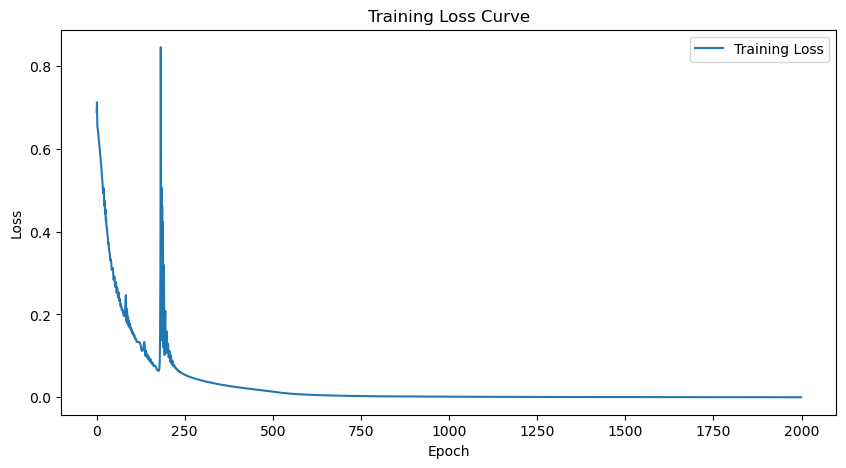

Final Model Accuracy: 75.22%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_PCA2.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.79      0.67      0.73       283
non_infringement       0.73      0.83      0.77       298

        accuracy                           0.75       581
       macro avg       0.76      0.75      0.75       581
    weighted avg       0.76      0.75      0.75       581



/tmp/ipykernel_2600731/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
